In [1]:
import os
import numpy as np
import random
import torch

def reset_seeds(seed=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
  np.random.seed(seed)
  torch.manual_seed(seed) # cpu 연산 무작위 고정
  torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
  torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import koreanize_matplotlib  # matplotlib 한글화
warnings.filterwarnings(action='ignore')

In [3]:
import easydict
args = easydict.EasyDict()

# path info
args.default_path = "../data/"
args.all_csv = args.default_path + "Telco_customer.csv"
#args.default_submission_csv = args.default_path + "submission.csv"

# 제출용
# args.submission_csv = "submission_0213_01.csv"

In [4]:
import pandas as pd
ori_all = pd.read_csv(args.all_csv)
ori_all.shape

(7043, 21)

## 3.EDA

In [5]:
# 미리 Churn를 바꿔 놓는게 마음이 편하다.
ori_all['Churn'] = ori_all['Churn'].apply(lambda x : 1 if x == "Yes" else 0 )

# TotalCharges도 마찬가지로 수치형으로 바꿔놓자.
# pd.to_numeric() : 특히 문자열로 저장된 숫자를 정수(int) 또는 부동소수점(float) 숫자로 변환
ori_all['TotalCharges'] = ori_all['TotalCharges'].replace(" ", "0")  # 공백을 '0'으로 변환
ori_all['TotalCharges'] = pd.to_numeric(ori_all['TotalCharges'])  # 숫자로 변환


- PhoneService와 gender는 Churn과 관련성이 적음

In [6]:
# 카이제곱 검정 : 수가 크면 타겟값과 연관이 없음!
import scipy.stats as stats
import pandas as pd
# 범주형 변수 리스트
cat_cols = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
            'DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod', ]

print("카이제곱 검정 결과 : ")
for col in cat_cols:
    ct = pd.crosstab(ori_all[col], ori_all['Churn'])  # 교차표 생성
    chi2, p, dof, expected = stats.chi2_contingency(ct)  # 카이제곱 검정
    print(f"[{col}] vs Churn: p-value = {p:.5f}")

카이제곱 검정 결과 : 
[gender] vs Churn: p-value = 0.48658
[SeniorCitizen] vs Churn: p-value = 0.00000
[Partner] vs Churn: p-value = 0.00000
[Dependents] vs Churn: p-value = 0.00000
[PhoneService] vs Churn: p-value = 0.33878
[MultipleLines] vs Churn: p-value = 0.00346
[InternetService] vs Churn: p-value = 0.00000
[OnlineSecurity] vs Churn: p-value = 0.00000
[OnlineBackup] vs Churn: p-value = 0.00000
[DeviceProtection] vs Churn: p-value = 0.00000
[TechSupport] vs Churn: p-value = 0.00000
[StreamingTV] vs Churn: p-value = 0.00000
[StreamingMovies] vs Churn: p-value = 0.00000
[Contract] vs Churn: p-value = 0.00000
[PaperlessBilling] vs Churn: p-value = 0.00000
[PaymentMethod] vs Churn: p-value = 0.00000


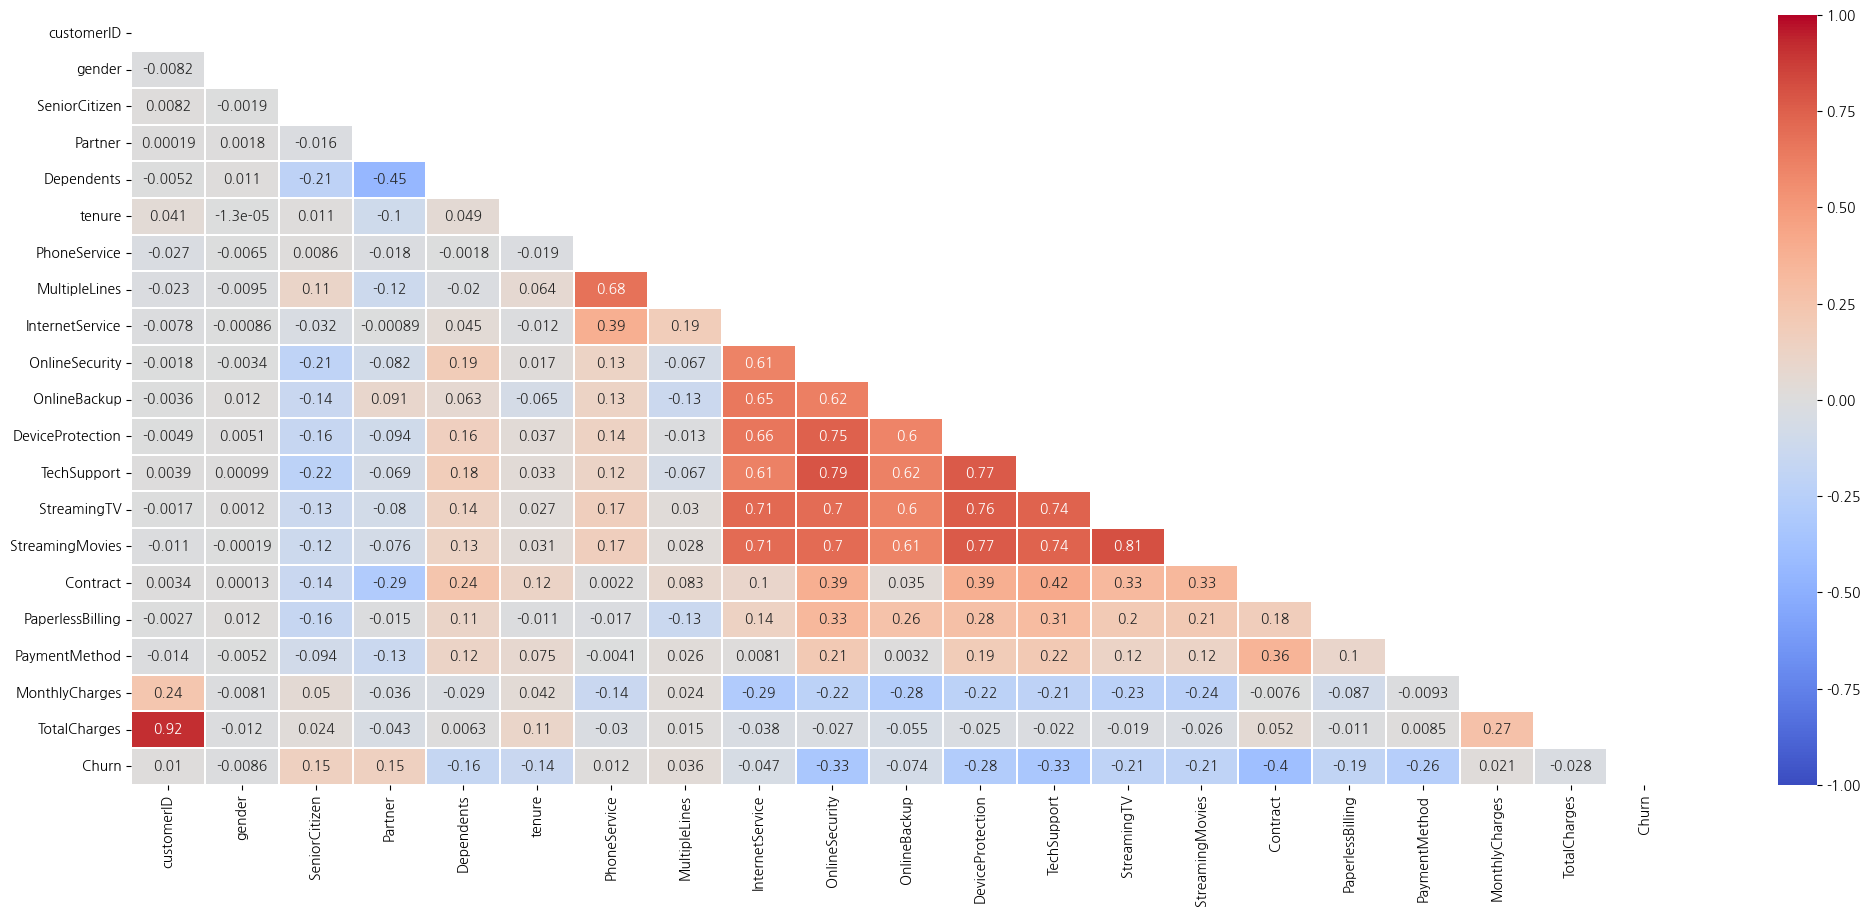

In [7]:
# 히트맵 그리기
plt.figure(figsize=(25, 10))

corr = ori_all.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap='coolwarm', vmin=-1, vmax=1)

In [8]:
ori_all.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304,0.265370
std,0.368612,24.559481,30.090047,2266.794470,0.441561
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,398.550000,0.000000
50%,0.000000,29.000000,70.350000,1394.550000,0.000000
75%,0.000000,55.000000,89.850000,3786.600000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


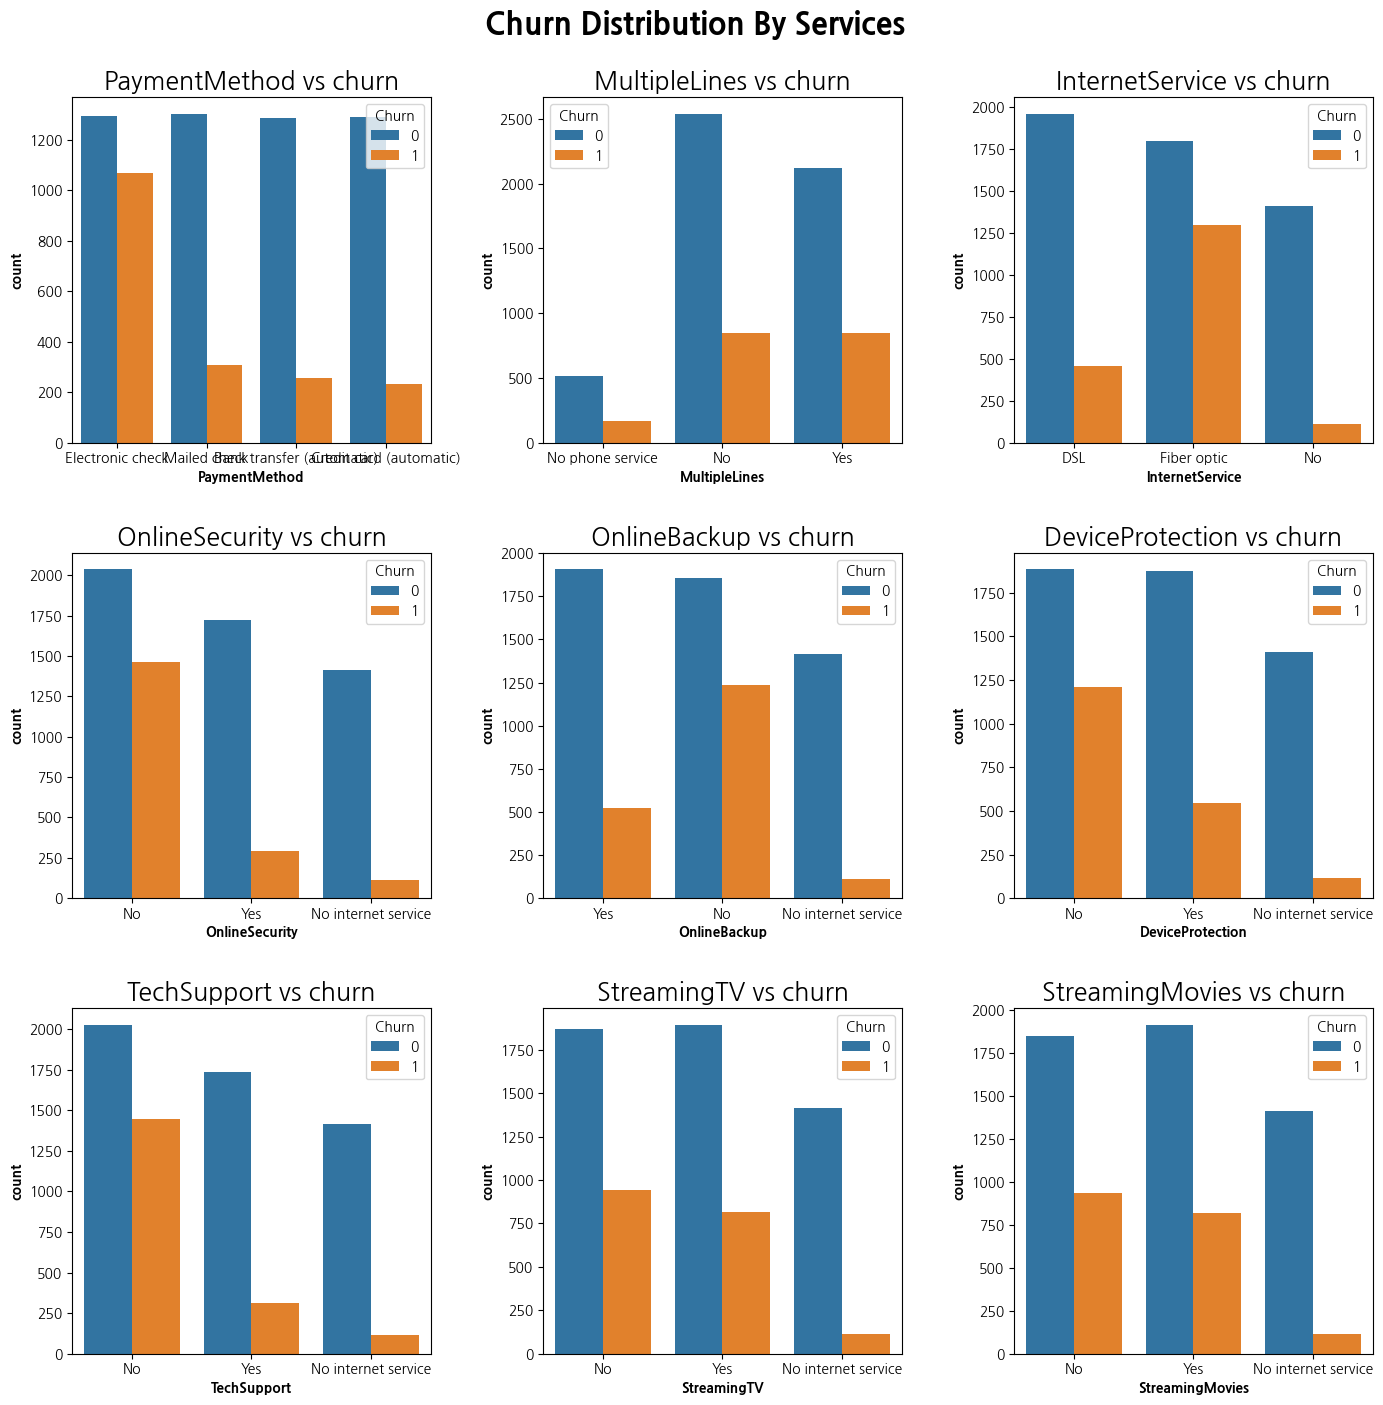

In [9]:
fig,axes= plt.subplots(3,3, figsize=(14,14))
axes= axes.flatten()

service_cols= ['PaymentMethod', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

for i, service in enumerate(service_cols):
    sns.countplot(data=ori_all,x=service, hue='Churn',ax=axes[i])
    axes[i].set_title(f"{service} vs churn", fontsize= 18)
    axes[i].set_xlabel(service, fontweight='bold')
    axes[i].set_ylabel("count", fontweight='bold')
   
    
plt.suptitle("Churn Distribution By Services", fontsize=22, fontweight='bold', y=1)
plt.tight_layout(h_pad=3)
plt.show()

In [10]:
ori_example = ori_all[(ori_all['Churn']==1) & (ori_all['PaymentMethod']=='Electronic check')]
print(len(ori_example)) 

1071


In [ ]:
ori_example = ori_all[(ori_all['Churn']==1) & (ori_all['Contract']=='Month-to-month')]
print("이탈한 고객수 : ", len(ori_all[ori_all['Churn']==1]))
print("이탈 O & Month-to-month 계약 O : ", len(ori_example)) 
print("이탈 O & Month-to-month 계약 O & TechSupport를 쓰지 않음 : ",len(ori_example[ori_example['TechSupport']=='No'])) 

1350
1655


In [ ]:
ori_example = ori_all.groupby(["Partner","Dependents"])
ori_example['Churn'].sum()

In [12]:
ori_all['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [13]:
ori_example = ori_all.groupby(["InternetService"])
ori_example['Churn'].agg(['mean','count', 'sum'])

,mean,count,sum
InternetService,,,
DSL,0.189591,2421,459
Fiber optic,0.418928,3096,1297
No,0.074050,1526,113


- 이탈함(Yes) : 1869명
- 이탈안함(No) : 5174명

In [14]:
ori_example = ori_all.groupby("Churn")
ori_example.count()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
Churn,,,,,,,,,,,,,,,,,,,,
0,5174,5174,5174,5174,5174,5174,5174,5174,5174,5174,5174,5174,5174,5174,5174,5174,5174,5174,5174,5174
1,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869


- 이탈한 고객 1869명 중 노인 고객 : 476명 (이탈한 고객의 25%)
- 이탈안한 고객 4508명 중 노인 고객 : 666명 (이탈안한 고객의 14%)

- **이탈율**
- 인터넷 가입 x : 7.4%
- 인터넷 온라인 백업 o, 인터넷 온라인 보안 o : 10%
- 인터넷 온라인 백업 o, 인터넷 온라인 보안 x : 31%
- 인터넷 온라인 백업 x, 인터넷 온라인 보안 o : 19%
- 인터넷 온라인 백업 x, 인터넷 온라인 보안 x : 48%

In [15]:
ori_example = ori_all.groupby(["OnlineBackup","OnlineSecurity"])
ori_example[['Churn']].mean()

Churn
OnlineBackup        OnlineSecurity               
No                  No                   0.481549
                    Yes                  0.197088
No internet service No internet service  0.074050
Yes                 No                   0.310054
                    Yes                  0.105684

In [16]:
# TotalCharges의 먼저 수치화해야 되므로 data Cleaning을 먼저 해준다.
# pd.to_numeric() : 특히 문자열로 저장된 숫자를 정수(int) 또는 부동소수점(float) 숫자로 변환
ori_all['TotalCharges'] = ori_all['TotalCharges'].replace(" ", "0")  # 공백을 '0'으로 변환
ori_all['TotalCharges'] = pd.to_numeric(ori_all['TotalCharges'])  # 숫자로 변환

In [17]:
# fiber optic이 가장 높은 가격()을 보인다.
ori_example = ori_all.groupby("InternetService")
ori_example['MonthlyCharges'].median()

InternetService
DSL            56.150
Fiber optic    91.675
No             20.150
Name: MonthlyCharges, dtype: float64

In [18]:
crosstab_percentage = pd.crosstab(ori_all[ori_all['Churn'] == 1]['Contract'], ori_all[ori_all['Churn'] == 1]['Churn'])  # 행 기준으로 비율 계산
print(crosstab_percentage)

Churn              1
Contract            
Month-to-month  1655
One year         166
Two year          48
